In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
imdb_df = pd.read_csv('IMDB Dataset.csv')
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
imdb_df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [4]:
imdb_reviews = imdb_df['review'].tolist()

imdb_df['total_line'] = [len(word.split()) for word in imdb_reviews]
imdb_df['line_number'] = [word[0] for word in enumerate(imdb_reviews)]

In [5]:
imdb_df.head()

,review,sentiment,total_line,line_number
0,One of the other reviewers has mentioned that ...,positive,307,0
1,A wonderful little production. <br /><br />The...,positive,162,1
2,I thought this was a wonderful way to spend ti...,positive,166,2
3,Basically there's a family where a little boy ...,negative,138,3
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,4


In [6]:
imdb_df['sentiment'] = imdb_df['sentiment'].replace({'positive', 'negative'}, {1,0})

In [7]:
imdb_df.head()

,review,sentiment,total_line,line_number
0,One of the other reviewers has mentioned that ...,0,307,0
1,A wonderful little production. <br /><br />The...,0,162,1
2,I thought this was a wonderful way to spend ti...,0,166,2
3,Basically there's a family where a little boy ...,1,138,3
4,"Petter Mattei's ""Love in the Time of Money"" is...",0,230,4


In [8]:
from numpy.random import RandomState

rng = RandomState()

train_df = imdb_df.sample(frac=0.7, random_state=rng)
val_df = imdb_df.loc[~imdb_df.index.isin(train_df.index)]

In [9]:
len(train_df), len(val_df)

(35000, 15000)

In [10]:
train_sentences = train_df['review'].tolist()
val_sentences = val_df['review'].tolist()

In [11]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['sentiment'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['sentiment'].to_numpy().reshape(-1,1))

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['sentiment'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['sentiment'].to_numpy())

train_labels_encoded

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(
    train_sentences,
    train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [14]:
model_0.score(val_sentences, val_labels_encoded)

0.8680666666666667

In [15]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    model_results = {
        "accuracy":model_accuracy,
        "precision":model_precision,
        "recall":model_recall,
        "f1-score":model_f1
    }
    return model_results

In [17]:
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 86.80666666666667,
 'precision': 0.8686197340101557,
 'recall': 0.8680666666666667,
 'f1-score': 0.8679882463152516}

In [18]:
#Model-1

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.round(np.mean(sent_lens))
avg_sent_len

231.0

(array([1.5469e+04, 1.2205e+04, 4.0420e+03, 1.7170e+03, 8.0400e+02,
        4.3400e+02, 3.0300e+02, 1.1000e+01, 3.0000e+00, 3.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   8.        ,  159.33333333,  310.66666667,  462.        ,
         613.33333333,  764.66666667,  916.        , 1067.33333333,
        1218.66666667, 1370.        , 1521.33333333, 1672.66666667,
        1824.        , 1975.33333333, 2126.66666667, 2278.        ]),
 <BarContainer object of 15 artists>)

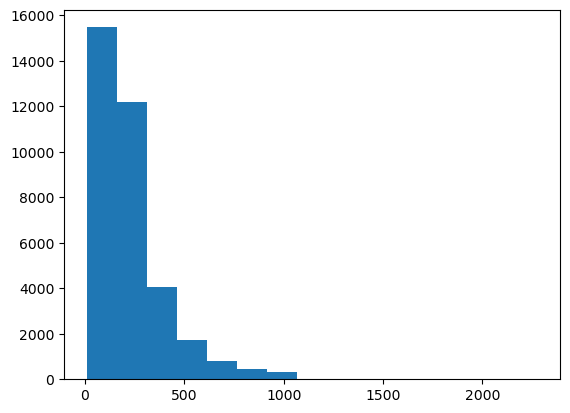

In [19]:
plt.hist(sent_lens, bins=15)

In [20]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

591

In [21]:
max_tokens = 68000

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len,
    pad_to_max_tokens=True
)

text_vectorizer.adapt(train_sentences)

In [22]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 didn't sound like it was from a fantasy film. The film is dark, with dark overtones. The soundtrack way too uplifting to the point it intruded on the visuals. I'm sure they were aiming for something militant, but it just didn't work. The scene when Astin is attempting to escape is a perfect example. Why does it sound like the Goonies? There is no comedy, there is no brightness to this!! <br /><br />The idea of the movie is great, and the acting is very good as well. I enjoyed everyone's performances. It's available on Netflix's online viewing. <br /><br />Definitely worth a viewing, but write your own soundtrack!!

Length of text: 621

Vectorized text: [[  150   449    39     9    14    36     4  1072    20     2    20     7
    442    16   442  8687     2   719    97   101  4868     6     2   222
      9 48140    21     2  1995   142   247    35    66  6351    17   138
  16893    19     9    41   150   164     2   131    51 13284     7  2851
      6  1014     7     4   399   47

In [23]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 591,
 'pad_to_max_tokens': True}

In [24]:
token_embed = tf.keras.layers.Embedding(
    input_dim = 68000,
    output_dim = 128,
    mask_zero=True,
    name='token_embedding'
)

In [25]:
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
print(f"Vectorized sentence shape: {vectorized_sentence.shape}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 didn't sound like it was from a fantasy film. The film is dark, with dark overtones. The soundtrack way too uplifting to the point it intruded on the visuals. I'm sure they were aiming for something militant, but it just didn't work. The scene when Astin is attempting to escape is a perfect example. Why does it sound like the Goonies? There is no comedy, there is no brightness to this!! <br /><br />The idea of the movie is great, and the acting is very good as well. I enjoyed everyone's performances. It's available on Netflix's online viewing. <br /><br />Definitely worth a viewing, but write your own soundtrack!!

Sentence after vectorization (before embedding):
 [[  150   449    39     9    14    36     4  1072    20     2    20     7
    442    16   442  8687     2   719    97   101  4868     6     2   222
      9 48140    21     2  1995   142   247    35    66  6351    17   138
  16893    19     9    41   150   164     2   131    51 13284     7  2851

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

train_dataset, val_dataset

(<TensorSliceDataset shapes: ((), (2,)), types: (tf.string, tf.float64)>,
 <TensorSliceDataset shapes: ((), (2,)), types: (tf.string, tf.float64)>)

In [27]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [28]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_Conv1D_token')

model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [29]:
model_1.summary()

Model: "model_1_Conv1D_token"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 591)               0         
_________________________________________________________________
token_embedding (Embedding)  (None, 591, 128)          8704000   
_________________________________________________________________
conv1d (Conv1D)              (None, 587, 64)           41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 8,745,154
Trainable params: 8,745,154
Non-trainable params: 0
____________________________________

In [30]:
model_1_history = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_dataset))
)

Epoch 1/5
109/109 [==============================] - 10s 35ms/step - loss: 0.6664 - accuracy: 0.6064 - val_loss: 0.5641 - val_accuracy: 0.7765
Epoch 2/5
109/109 [==============================] - 4s 34ms/step - loss: 0.4323 - accuracy: 0.8417 - val_loss: 0.3520 - val_accuracy: 0.8641
Epoch 3/5
109/109 [==============================] - 4s 33ms/step - loss: 0.3473 - accuracy: 0.8615 - val_loss: 0.3047 - val_accuracy: 0.8886
Epoch 4/5
109/109 [==============================] - 4s 33ms/step - loss: 0.3080 - accuracy: 0.8784 - val_loss: 0.3005 - val_accuracy: 0.8818
Epoch 5/5
109/109 [==============================] - 4s 33ms/step - loss: 0.2928 - accuracy: 0.8847 - val_loss: 0.2976 - val_accuracy: 0.8886


In [31]:
model_1.evaluate(val_dataset)

469/469 [==============================] - 4s 9ms/step - loss: 0.2979 - accuracy: 0.8844


[0.29791155457496643, 0.8844000101089478]

In [32]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[0.9109726 , 0.08902743],
       [0.9284943 , 0.07150576],
       [0.28505626, 0.71494377],
       ...,
       [0.00241265, 0.9975873 ],
       [0.95520484, 0.04479516],
       [0.17301579, 0.8269842 ]], dtype=float32)

In [33]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(15000,), dtype=int64, numpy=array([0, 0, 1, ..., 1, 0, 1], dtype=int64)>

In [34]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 88.44,
 'precision': 0.8888401526570356,
 'recall': 0.8844,
 'f1-score': 0.8841333727041757}

In [35]:
baseline_results

{'accuracy': 86.80666666666667,
 'precision': 0.8686197340101557,
 'recall': 0.8680666666666667,
 'f1-score': 0.8679882463152516}

In [36]:
#Model_2

import tensorflow_hub as hub

uni_sentence_encoder = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                     name='uni_sentence_encoder')

In [37]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = uni_sentence_encoder([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 This is a great film Classic from the 40's and well produced. There are very dramatic scenes in this film with John Garfield,(Al Schmid),"Force of Evil",'48 and Dane Clark,(Lee Diamond),"Last Rites",'88, fighting the Japs during WWII being completely surrounded and with only one machine-gun. When Al Schmid was able to go home after being wounded with a horrible injury, his problems just started to begin with his family and engaged girl friend. Dane Clark gave an outstanding supporting role as Lee Diamond, who did everything to help his buddy Al get his life together again. There is never a complete victory to War and lets not forget all the Brave Wounded Military personnel in Veterans Hospitals from All the Wars and our present Iraq Vets!
Sentence after embedding:
 [-0.01456863 -0.01505403  0.02806196 -0.00085736  0.03347155  0.00501772
 -0.04448452 -0.03030549  0.0560262  -0.01013866  0.07323448 -0.0406712
  0.03109628  0.02802359  0.06962666 -0.07294684 -0.06993462 

In [38]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = uni_sentence_encoder(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(2, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE')

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
uni_sentence_encoder (KerasL (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 256,863,746
Trainable params: 65,922
Non-trainable params: 256,797,824
_________________________________________________________________


In [40]:
model_2_history = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    validation_data = val_dataset,
    epochs=5,
    validation_steps = int(0.1 * len(val_dataset))
)

Epoch 1/5
109/109 [==============================] - 11s 82ms/step - loss: 0.4924 - accuracy: 0.7964 - val_loss: 0.3778 - val_accuracy: 0.8410
Epoch 2/5
109/109 [==============================] - 8s 71ms/step - loss: 0.3440 - accuracy: 0.8538 - val_loss: 0.3464 - val_accuracy: 0.8492
Epoch 3/5
109/109 [==============================] - 8s 71ms/step - loss: 0.3439 - accuracy: 0.8420 - val_loss: 0.3402 - val_accuracy: 0.8594
Epoch 4/5
109/109 [==============================] - 8s 70ms/step - loss: 0.3401 - accuracy: 0.8521 - val_loss: 0.3512 - val_accuracy: 0.8431
Epoch 5/5
109/109 [==============================] - 8s 73ms/step - loss: 0.3372 - accuracy: 0.8503 - val_loss: 0.3385 - val_accuracy: 0.8546


In [41]:
model_2.evaluate(val_dataset)

469/469 [==============================] - 24s 50ms/step - loss: 0.3344 - accuracy: 0.8562


[0.33438241481781006, 0.8561999797821045]

In [42]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[0.8211173 , 0.17888267],
       [0.82968974, 0.17031029],
       [0.14761953, 0.8523805 ],
       ...,
       [0.00436683, 0.9956332 ],
       [0.57684296, 0.42315704],
       [0.06875284, 0.9312471 ]], dtype=float32)

In [43]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(15000,), dtype=int64, numpy=array([0, 0, 1, ..., 1, 0, 1], dtype=int64)>

In [44]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 85.61999999999999,
 'precision': 0.8574103694053761,
 'recall': 0.8562,
 'f1-score': 0.856122924135613}

In [45]:
#Model-3

def split_chars(text):
    return " ".join(list(text))

In [46]:
split_chars(random_train_sentence)

'T h i s   i s   a   g r e a t   f i l m   C l a s s i c   f r o m   t h e   4 0 \' s   a n d   w e l l   p r o d u c e d .   T h e r e   a r e   v e r y   d r a m a t i c   s c e n e s   i n   t h i s   f i l m   w i t h   J o h n   G a r f i e l d , ( A l   S c h m i d ) , " F o r c e   o f   E v i l " , \' 4 8   a n d   D a n e   C l a r k , ( L e e   D i a m o n d ) , " L a s t   R i t e s " , \' 8 8 ,   f i g h t i n g   t h e   J a p s   d u r i n g   W W I I   b e i n g   c o m p l e t e l y   s u r r o u n d e d   a n d   w i t h   o n l y   o n e   m a c h i n e - g u n .   W h e n   A l   S c h m i d   w a s   a b l e   t o   g o   h o m e   a f t e r   b e i n g   w o u n d e d   w i t h   a   h o r r i b l e   i n j u r y ,   h i s   p r o b l e m s   j u s t   s t a r t e d   t o   b e g i n   w i t h   h i s   f a m i l y   a n d   e n g a g e d   g i r l   f r i e n d .   D a n e   C l a r k   g a v e   a n   o u t s t a n d i n g   s u p p o r t i n g   r o l e   a s   

In [47]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

In [48]:
chars_len = [len(letter) for letter in train_chars]
mean_char_len = np.mean(chars_len)
mean_char_len

2615.5225714285716

(array([1.5851e+04, 1.1798e+04, 4.0430e+03, 1.7190e+03, 8.1800e+02,
        4.4500e+02, 2.8800e+02, 1.8000e+01, 8.0000e+00, 3.0000e+00,
        4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([   81.        ,  1807.26666667,  3533.53333333,  5259.8       ,
         6986.06666667,  8712.33333333, 10438.6       , 12164.86666667,
        13891.13333333, 15617.4       , 17343.66666667, 19069.93333333,
        20796.2       , 22522.46666667, 24248.73333333, 25975.        ]),
 <BarContainer object of 15 artists>)

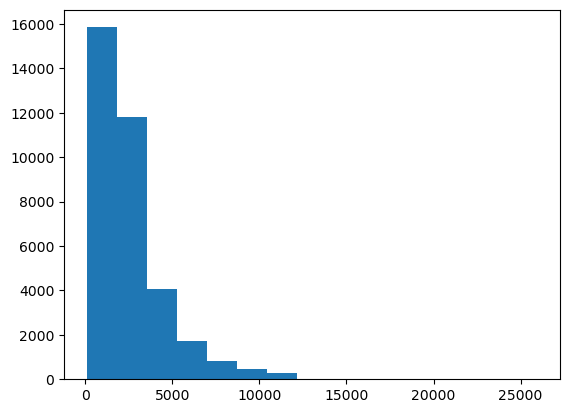

In [49]:
plt.hist(chars_len, bins=15)

In [50]:
output_seq_char_len = int(np.percentile(chars_len, 95))
output_seq_char_len

6761

In [51]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [52]:
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    name='char_vectorizer'
)

char_vectorizer.adapt(train_chars)

In [53]:
char_vectorizer.get_config()

{'name': 'char_vectorizer',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 6761,
 'pad_to_max_tokens': False}

In [54]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"Vectorized chars shape: {vectorized_chars.shape}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 I   a g r e e   w i t h   m o s t   o f   M r .   R i v e r a ' s   c o m m e n t s ,   a n d   I   j u s t   w a n t   t o   a d   a   c o u p l e   o f   c a v e a t s .   T h i s   f i l m ,   " T h e   M a s c o t "   i s   c r i m i n a l l y   n e g l e c t e d   i n   i t s   c u r r e n t   f o r m .   F o r   t h a t   m a t t e r ,   s o   i s   " V a m p y r " .   " T h e   M a s c o t "   i s n ' t   a   " b o n u s   f e a t u r e " - -   i t ' s   t a c k e d   o n   a s   a   c h a p t e r   i n   " V a m p y r " .   E v e n   t h o u g h   i t ' s   m a d e   v e r y   c l e a r   t h a t   t h i s   i s   a   s e p a r a t e   m o v i e ,   i t   s h o u l d   h a v e   b e e n   t r e a t e d   a s   s u c h   b y   t h e   m a n u f a c t u r e r s .   A n d   w h i l e   I " m   a t   i t ,   " V a m p y r "   n e e d s   s o m e   o f   t h a t   s a m e   r e s p e c t   a n d   c l e a n i n g   u p   a s   w e l l .   I   g o t   t h e   f e e l

In [55]:
char_embed = layers.Embedding(
    input_dim=28,
    output_dim=25,
    mask_zero=True,
    name='char_embed'
)

In [56]:
print(f"Charified text: {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars:\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text: I   a g r e e   w i t h   m o s t   o f   M r .   R i v e r a ' s   c o m m e n t s ,   a n d   I   j u s t   w a n t   t o   a d   a   c o u p l e   o f   c a v e a t s .   T h i s   f i l m ,   " T h e   M a s c o t "   i s   c r i m i n a l l y   n e g l e c t e d   i n   i t s   c u r r e n t   f o r m .   F o r   t h a t   m a t t e r ,   s o   i s   " V a m p y r " .   " T h e   M a s c o t "   i s n ' t   a   " b o n u s   f e a t u r e " - -   i t ' s   t a c k e d   o n   a s   a   c h a p t e r   i n   " V a m p y r " .   E v e n   t h o u g h   i t ' s   m a d e   v e r y   c l e a r   t h a t   t h i s   i s   a   s e p a r a t e   m o v i e ,   i t   s h o u l d   h a v e   b e e n   t r e a t e d   a s   s u c h   b y   t h e   m a n u f a c t u r e r s .   A n d   w h i l e   I " m   a t   i t ,   " V a m p y r "   n e e d s   s o m e   o f   t h a t   s a m e   r e s p e c t   a n d   c l e a n i n g   u p   a s   w e l l .   I   g o t   t h e   f e e l 

In [57]:
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [58]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_Conv1D_Char')

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [59]:
model_3.summary()

Model: "model_3_Conv1D_Char"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 6761)              0         
_________________________________________________________________
char_embed (Embedding)       (None, 6761, 25)          700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6757, 64)          8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 8,894
Trainable params: 8,894
Non-trainable params: 0
_____________________________________________

In [60]:
model_3_history = model_3.fit(
    train_char_dataset,
    epochs=5,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_char_dataset))
)

Epoch 1/5
109/109 [==============================] - 8s 66ms/step - loss: 0.6911 - accuracy: 0.5258 - val_loss: 0.6932 - val_accuracy: 0.5034
Epoch 2/5
109/109 [==============================] - 7s 64ms/step - loss: 0.6762 - accuracy: 0.6101 - val_loss: 0.6933 - val_accuracy: 0.5054
Epoch 3/5
109/109 [==============================] - 7s 64ms/step - loss: 0.6431 - accuracy: 0.6944 - val_loss: 0.6930 - val_accuracy: 0.5143
Epoch 4/5
109/109 [==============================] - 7s 64ms/step - loss: 0.5847 - accuracy: 0.7388 - val_loss: 0.6919 - val_accuracy: 0.5333
Epoch 5/5
109/109 [==============================] - 7s 64ms/step - loss: 0.5358 - accuracy: 0.7526 - val_loss: 0.7049 - val_accuracy: 0.4871


In [61]:
model_3.evaluate(val_char_dataset)

469/469 [==============================] - 12s 27ms/step - loss: 0.5349 - accuracy: 0.7325


[0.5348772406578064, 0.7324666380882263]

In [62]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.59037524, 0.40962476],
       [0.9028249 , 0.09717509],
       [0.54453725, 0.45546278],
       ...,
       [0.23516947, 0.7648305 ],
       [0.9357228 , 0.06427719],
       [0.28971094, 0.71028906]], dtype=float32)

In [63]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(15000,), dtype=int64, numpy=array([0, 0, 0, ..., 1, 0, 1], dtype=int64)>

In [64]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 73.24666666666667,
 'precision': 0.7678029806762598,
 'recall': 0.7324666666666667,
 'f1-score': 0.7240011074298828}

In [65]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = uni_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

token_char_concat = tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(2, activation='softmax')(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name='model_4_token_and_char_embeddings')

In [66]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 6761)         0           input_4[0][0]                    
__________________________________________________________________________________________________
uni_sentence_encoder (KerasLaye (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

In [67]:
model_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [68]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [69]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 2)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 2)), types: ((tf.string, tf.string), tf.float64)>)

In [70]:
model_4_history = model_4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1*len(train_char_token_dataset)),
    epochs=5,
    validation_data = val_char_token_dataset,
    validation_steps = int(0.1 * len(val_char_token_dataset))
)

Epoch 1/5
109/109 [==============================] - 42s 285ms/step - loss: 0.5466 - accuracy: 0.7299 - val_loss: 0.3896 - val_accuracy: 0.8254
Epoch 2/5
109/109 [==============================] - 27s 247ms/step - loss: 0.3754 - accuracy: 0.8354 - val_loss: 0.3437 - val_accuracy: 0.8478
Epoch 3/5
109/109 [==============================] - 27s 248ms/step - loss: 0.3748 - accuracy: 0.8377 - val_loss: 0.3372 - val_accuracy: 0.8587
Epoch 4/5
109/109 [==============================] - 27s 244ms/step - loss: 0.3540 - accuracy: 0.8521 - val_loss: 0.3434 - val_accuracy: 0.8471
Epoch 5/5
109/109 [==============================] - 29s 262ms/step - loss: 0.3564 - accuracy: 0.8498 - val_loss: 0.3322 - val_accuracy: 0.8553


In [71]:
model_4.evaluate(val_char_token_dataset)

469/469 [==============================] - 46s 98ms/step - loss: 0.3310 - accuracy: 0.8565


[0.3309708535671234, 0.8564666509628296]

In [72]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[0.7774373 , 0.22256264],
       [0.83999884, 0.16000117],
       [0.09827329, 0.90172666],
       ...,
       [0.00285478, 0.99714524],
       [0.596512  , 0.40348792],
       [0.06597484, 0.93402517]], dtype=float32)

In [73]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(15000,), dtype=int64, numpy=array([0, 0, 1, ..., 1, 0, 1], dtype=int64)>

In [74]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 85.64666666666668,
 'precision': 0.8578505003409471,
 'recall': 0.8564666666666667,
 'f1-score': 0.856375597665237}

In [75]:
train_df.head()

,review,sentiment,total_line,line_number
18904,I was 10 or eleven years old when this movie c...,0,241,18904
48085,"Amazing, one of my favorite movies way down at...",0,64,48085
27173,"Years ago, I caught a fairly well made TV movi...",1,211,27173
49866,Michael Keaton has really never been a good ac...,1,139,49866
23246,"I can honestly say that ""Death Bed: The Bed Th...",0,217,23246


<AxesSubplot:ylabel='Frequency'>

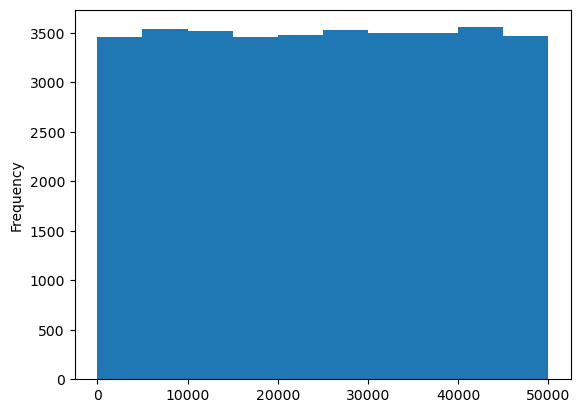

In [76]:
train_df.line_number.plot.hist()

47459